In [1]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"  # Or "jax" or "torch"!
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import matplotlib.pyplot as plt
import keras
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from keras.applications.resnet import preprocess_input
from keras.models import load_model
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import wandb
import seaborn as sns
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc, roc_auc_score
from sklearn.preprocessing import LabelBinarizer
import matplotlib as mpl
from keras.preprocessing import image
from scipy import interp
from tensorflow.keras.utils import plot_model, load_img, img_to_array, array_to_img
import random
from PIL import Image

gpus = tf.config.list_physical_devices('GPU')
print(f'GPUs available: {gpus}')

GPUs available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
# Global variables
DATASET_DIR = 'data/MIT_split'
RESULTS_FOLDER = "results/2layers"
IMG_WIDTH = 32
IMG_HEIGHT = 32
BATCH_SIZE = 8
NUMBER_OF_EPOCHS = 50
N_LAST_LAYERS_TO_UNFREEZE = 0

In [3]:
def save_history(history, result, result_name, model, notes=None):
    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.savefig(f"{RESULTS_FOLDER}/{result_name}/accuracy.jpg")
    plt.close()

    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('Loss (CELoss)')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.savefig(f"{RESULTS_FOLDER}/{result_name}/loss.jpg")

    with open(f"{RESULTS_FOLDER}/{result_name}/eval_metrics.txt", 'w') as file:
        file.write(f'Accuracy: {result[1]}\n')
        file.write(f'Loss: {result[0]}\n')
        file.write(f'Number of parameters: {model.count_params()}\n')
        model.summary(print_fn=lambda x: file.write(x + '\n'))
        if notes:
            file.write(f"Notes: {notes}\n")

def create_dataset(directory, preprocess_args={}, shuffle=False):
    data_generator = ImageDataGenerator(
        preprocessing_function=preprocess_input,
        **preprocess_args
    )
    dataset = data_generator.flow_from_directory(
        directory=directory,
        target_size=(IMG_WIDTH, IMG_HEIGHT),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=shuffle
    )
    return dataset

In [4]:
# Create folders (if necessary)
os.makedirs(f"results/2layers/", exist_ok=True)
os.makedirs(f"model_files/2layers/", exist_ok=True)

# Define the data generator for data augmentation and preprocessing
train_preprocess_args = {
    "rotation_range":1,
    "width_shift_range":0.0,
    "height_shift_range":0.0,
    "shear_range":1.4,
    "zoom_range":0.0,
    "horizontal_flip":True,
    "vertical_flip":False
}
train_dataset = create_dataset("data/MIT_small_train_1/train/", shuffle=True)#, preprocess_args=train_preprocess_args, shuffle=True)
val_dataset = create_dataset('data/MIT_small_train_1/test/')
test_dataset = create_dataset('data/MIT_split/test/')

Found 400 images belonging to 8 classes.
Found 2288 images belonging to 8 classes.
Found 807 images belonging to 8 classes.


In [5]:
model = load_model(f"{RESULTS_FOLDER}/weno.keras")
model.compile(loss='categorical_crossentropy', optimizer=RMSprop(learning_rate=0.0027645685878352807), metrics=['accuracy'])
print(model.summary())
print(f"Number of parameters: {model.count_params()}")

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(8, 32, 32, 3)]          0         
_________________________________________________________________
conv2d (Conv2D)              (8, 32, 32, 8)            224       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (8, 16, 16, 8)            0         
_________________________________________________________________
dropout (Dropout)            (8, 16, 16, 8)            0         
_________________________________________________________________
conv2d_1 (Conv2D)            (8, 16, 16, 8)            584       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (8, 8, 8, 8)              0         
_________________________________________________________________
dropout_1 (Dropout)          (8, 8, 8, 8)              0     

In [6]:
result = model.evaluate(test_dataset)

101/101 [==============================] - 4s 9ms/step - loss: 1.1765 - accuracy: 0.6337


In [7]:
prediction_logits = model.predict(test_dataset); prediction_logits.shape

(807, 8)

In [8]:
predictions = np.argmax(prediction_logits, axis=1)
labels = test_dataset.labels
class_names = [k for k in test_dataset.class_indices.keys()]

In [9]:
accuracy_score(labels, predictions)

0.6344485749690211

## Confusion matrix

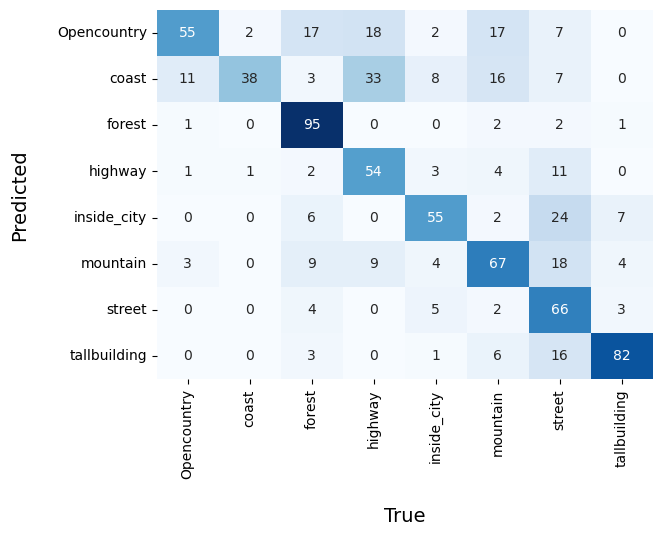

In [10]:
ax = sns.heatmap(confusion_matrix(labels, predictions), annot=True, cbar=False, cmap="Blues")

ax.set_xlabel("True", fontsize=14, labelpad=20)
ax.xaxis.set_ticklabels(class_names)
plt.xticks(rotation=90)

# set y-axis label and ticks
ax.set_ylabel("Predicted", fontsize=14, labelpad=20)
ax.yaxis.set_ticklabels(class_names)
plt.yticks(rotation=0);

## ROC Curve

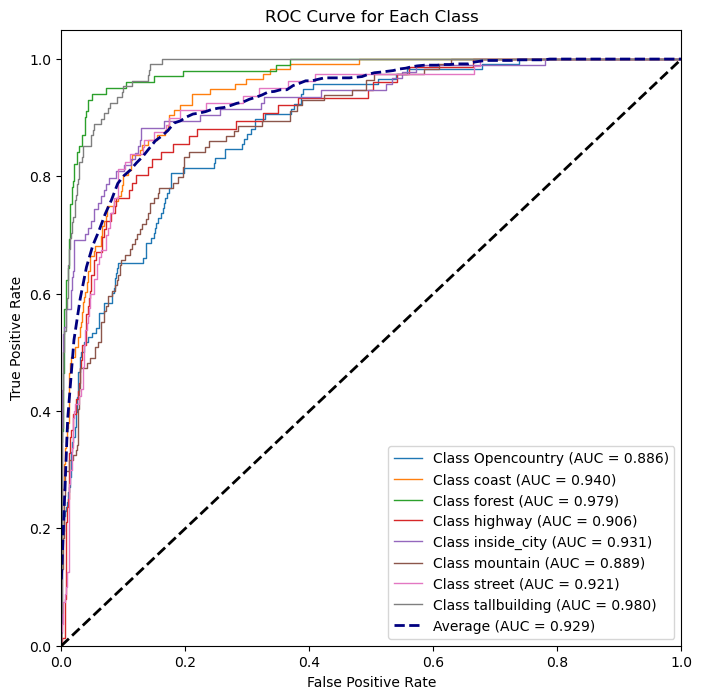

In [11]:
def compute_roc(test_labels, y_score, classes):
    # First, binarize the labels
    y_test = LabelBinarizer().fit_transform(test_labels)
    n_classes = y_test.shape[1]

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    plt.figure(figsize=(8, 8))

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

        # Plot each ROC curve without specifying color
        plt.plot(fpr[i], tpr[i], lw=1,
                 label='Class {0} (AUC = {1:0.3f})'.format(classes[i], roc_auc[i]))

    # Plot the average ROC curve without specifying color
    mean_tpr = np.mean([np.interp(np.linspace(0, 1, 100), fpr[i], tpr[i]) for i in range(n_classes)], axis=0)
    mean_auc = auc(np.linspace(0, 1, 100), mean_tpr)
    plt.plot(np.linspace(0, 1, 100), mean_tpr, color='navy', linestyle='--', lw=2,
             label='Average (AUC = {0:0.3f})'.format(mean_auc))

    # Customize plot details
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Each Class')

    # Adjust legend to avoid overlapping
    plt.legend(loc="lower right")

    # Save the plot
    plt.show()

compute_roc(test_dataset.labels, prediction_logits, class_names)


## Visualize data 

In [12]:
def visualize_images(images, labels, idxs, num_cols, name_to_id, preds=None, show_gt_pred=False):
    num_img = len(idxs)
    num_rows = int(np.ceil(num_img/num_cols))

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 6))

    idx_to_class =  {v: k for k, v in name_to_id.items()}

    for i, idx in enumerate(idxs):
        row = i // num_cols
        col = i % num_cols

        # Load and display the image using PIL
        image = Image.open(images[idx])
        axes[row, col].imshow(image)

        axes[row, col].axis('off')
        if show_gt_pred:
            axes[row, col].set_title(f'GT: {idx_to_class[labels[idx]]}, Pred:{idx_to_class[preds[idx]]}')
        else:
            axes[row, col].set_title(f'({idx}) {idx_to_class[labels[idx]]}')

    plt.tight_layout()
    plt.show()

#### Best class: Tallbuilding

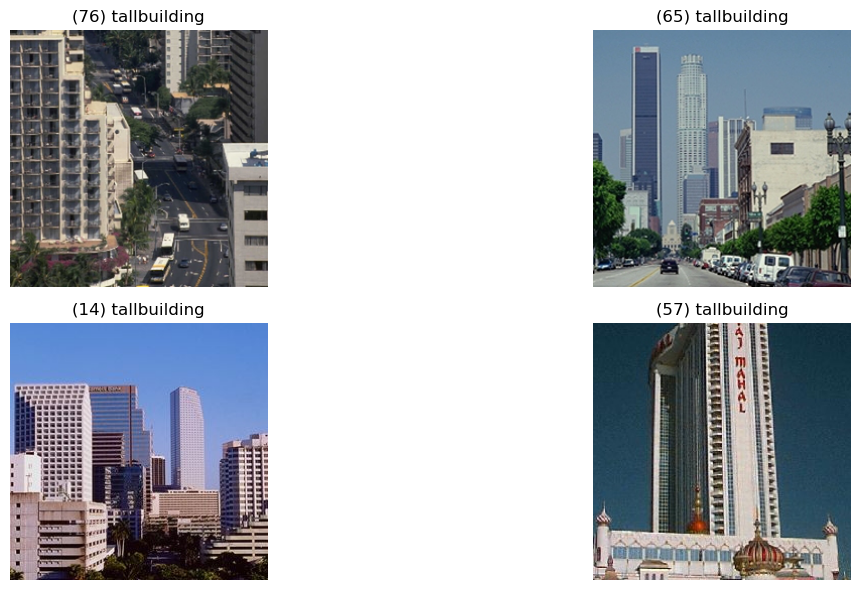

In [13]:
# tallbuilding instances well predicted
name_to_id = test_dataset.class_indices
labels_array = np.array(test_dataset.labels)
class_name = "tallbuilding"

preds = predictions[labels_array == name_to_id[class_name]][predictions[labels_array == name_to_id[class_name]] == name_to_id[class_name]]
gt = labels_array[labels_array == name_to_id[class_name]][predictions[labels_array == name_to_id[class_name]] == name_to_id[class_name]]
images = np.array(test_dataset.filepaths)[labels_array == name_to_id[class_name]][predictions[labels_array == name_to_id[class_name]] == name_to_id[class_name]]

num_samples = 4

all_indices = list(range(len(preds)))
random_indices = random.sample(all_indices, num_samples)
visualize_images(images, gt, random_indices, 2, name_to_id, preds=preds, show_gt_pred=False)

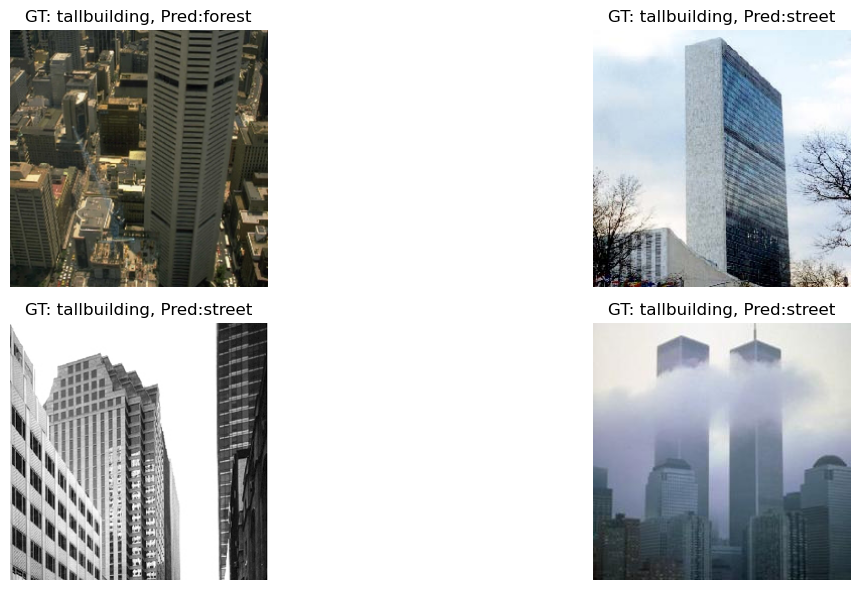

In [14]:
# tallbuilding instances that the model predicted as other class
name_to_id = test_dataset.class_indices
labels_array = np.array(test_dataset.labels)
class_name = "tallbuilding"

preds = predictions[labels_array == name_to_id[class_name]][predictions[labels_array == name_to_id[class_name]] != name_to_id[class_name]]
gt = labels_array[labels_array == name_to_id[class_name]][predictions[labels_array == name_to_id[class_name]] != name_to_id[class_name]]
images = np.array(test_dataset.filepaths)[labels_array == name_to_id[class_name]][predictions[labels_array == name_to_id[class_name]] != name_to_id[class_name]]

num_samples = 4

all_indices = list(range(len(preds)))
random_indices = random.sample(all_indices, num_samples)
visualize_images(images, gt, random_indices, 2, name_to_id, preds=preds, show_gt_pred=True)

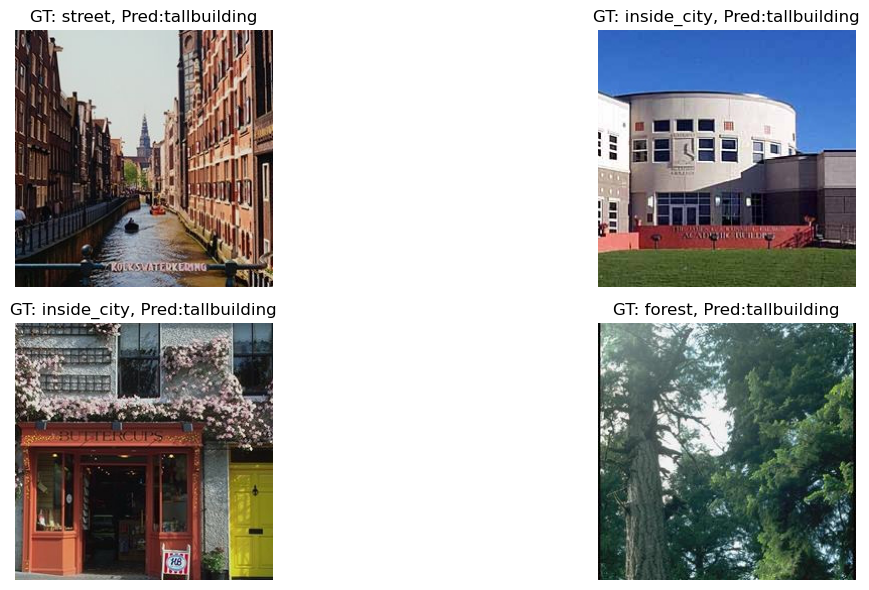

In [15]:
# Other instances that the model predicted as tallbuilding
name_to_id = test_dataset.class_indices
labels_array = np.array(test_dataset.labels)
class_name = "tallbuilding"

preds = predictions[labels_array != name_to_id[class_name]][predictions[labels_array != name_to_id[class_name]] == name_to_id[class_name]]
gt = labels_array[labels_array != name_to_id[class_name]][predictions[labels_array != name_to_id[class_name]] == name_to_id[class_name]]
images = np.array(test_dataset.filepaths)[labels_array != name_to_id[class_name]][predictions[labels_array != name_to_id[class_name]] == name_to_id[class_name]]

num_samples = 4

all_indices = list(range(len(preds)))
random_indices = random.sample(all_indices, num_samples)
visualize_images(images, gt, random_indices, 2, name_to_id, preds=preds, show_gt_pred=True)

#### Worst class: Opencountry

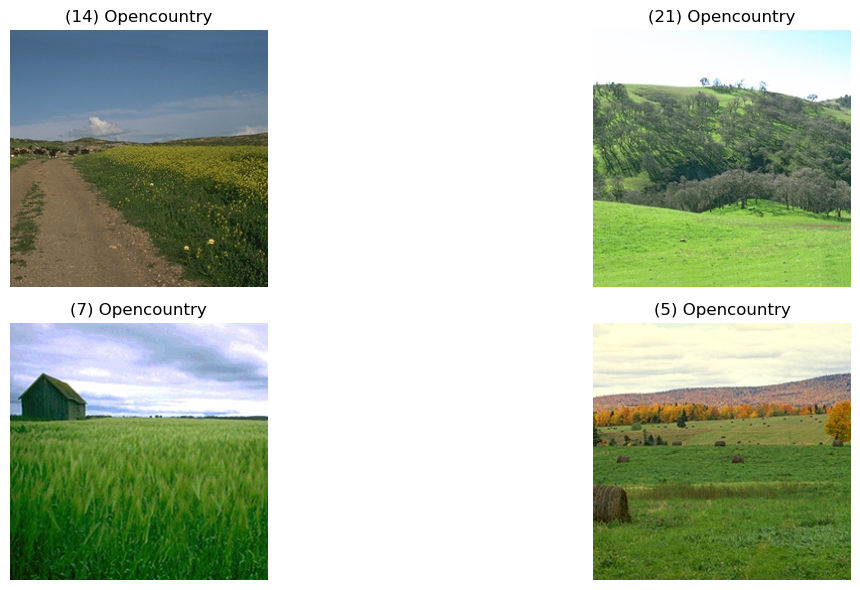

In [16]:
# Opencountry instances well predicted
name_to_id = test_dataset.class_indices
labels_array = np.array(test_dataset.labels)
class_name = "Opencountry"

preds = predictions[labels_array == name_to_id[class_name]][predictions[labels_array == name_to_id[class_name]] == name_to_id[class_name]]
gt = labels_array[labels_array == name_to_id[class_name]][predictions[labels_array == name_to_id[class_name]] == name_to_id[class_name]]
images = np.array(test_dataset.filepaths)[labels_array == name_to_id[class_name]][predictions[labels_array == name_to_id[class_name]] == name_to_id[class_name]]

num_samples = 4

all_indices = list(range(len(preds)))
random_indices = random.sample(all_indices, num_samples)
visualize_images(images, gt, random_indices, 2, name_to_id, preds=preds, show_gt_pred=False)

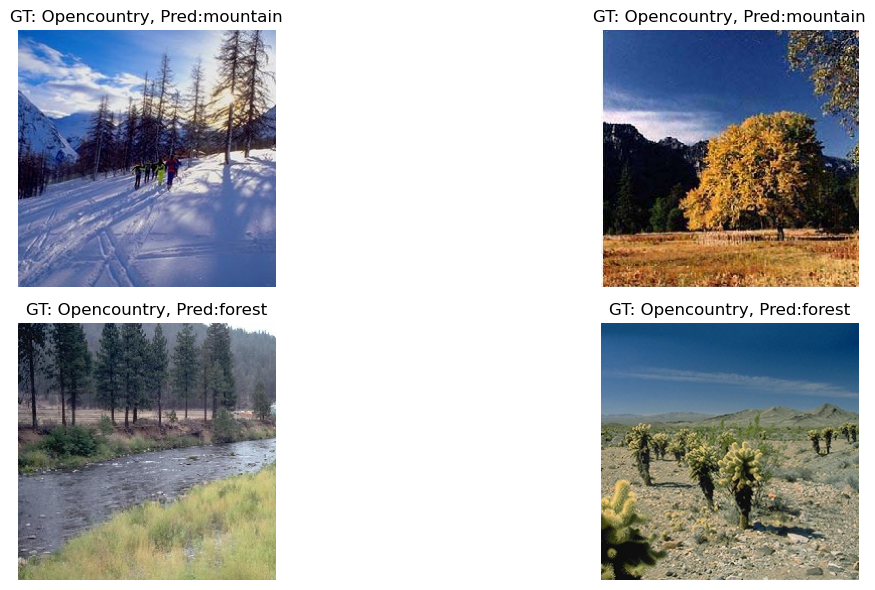

In [17]:
# Opencountry instances that the model predicted as other class
name_to_id = test_dataset.class_indices
labels_array = np.array(test_dataset.labels)
class_name = "Opencountry"

preds = predictions[labels_array == name_to_id[class_name]][predictions[labels_array == name_to_id[class_name]] != name_to_id[class_name]]
gt = labels_array[labels_array == name_to_id[class_name]][predictions[labels_array == name_to_id[class_name]] != name_to_id[class_name]]
images = np.array(test_dataset.filepaths)[labels_array == name_to_id[class_name]][predictions[labels_array == name_to_id[class_name]] != name_to_id[class_name]]

num_samples = 4

all_indices = list(range(len(preds)))
random_indices = random.sample(all_indices, num_samples)
visualize_images(images, gt, random_indices, 2, name_to_id, preds=preds, show_gt_pred=True)

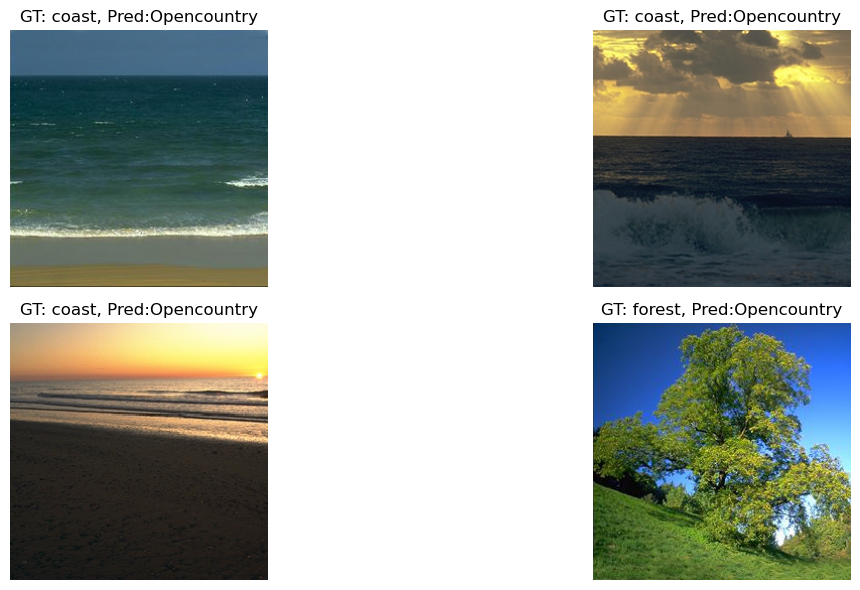

In [18]:
# Other instances that the model predicted as Opencountry
name_to_id = test_dataset.class_indices
labels_array = np.array(test_dataset.labels)
class_name = "Opencountry"

preds = predictions[labels_array != name_to_id[class_name]][predictions[labels_array != name_to_id[class_name]] == name_to_id[class_name]]
gt = labels_array[labels_array != name_to_id[class_name]][predictions[labels_array != name_to_id[class_name]] == name_to_id[class_name]]
images = np.array(test_dataset.filepaths)[labels_array != name_to_id[class_name]][predictions[labels_array != name_to_id[class_name]] == name_to_id[class_name]]

num_samples = 4

all_indices = list(range(len(preds)))
random_indices = random.sample(all_indices, num_samples)
visualize_images(images, gt, random_indices, 2, name_to_id, preds=preds, show_gt_pred=True)

## GradCAM

0 input_1
1 conv2d
2 max_pooling2d
3 dropout
4 conv2d_1
5 max_pooling2d_1
6 dropout_1
7 global_average_pooling2d
8 dense


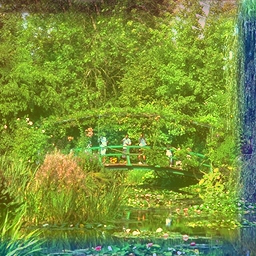

In [19]:
# function extracted from: https://keras.io/examples/vision/grad_cam/
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array

# function extracted from: https://keras.io/examples/vision/grad_cam/
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = keras.models.Model(
        model.inputs, [last_conv_layer_name.output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# function extracted from: https://keras.io/examples/vision/grad_cam/
def save_and_display_gradcam(img_path, heatmap, alpha=0.4):
    # Load the original image
    img = load_img(img_path)
    img = img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = mpl.colormaps["jet"]

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = array_to_img(superimposed_img)

    # Display Grad CAM
    display(superimposed_img)

model = load_model(f"{RESULTS_FOLDER}/weno.keras")

for i, l in enumerate(model.layers):
     print(i, l.name)

# Last conv layer
layer_index = 4
selected_layer = model.layers[layer_index]

img_path = './data/MIT_split/test/forest/land503.jpg'

img_size = (32, 32)
img = image.load_img(img_path, target_size=(32,32))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
img_array /= 255.0  # Normalize pixel values

# Get activations
activations = model.predict(img_array)

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model, selected_layer)

save_and_display_gradcam(img_path, heatmap)